## Installs

In [1]:
# ImageNetLibrary
!pip install timm -q
# model visualize
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=28020fccc750ee67fcee173c0dcd0243db8d8fb44df1bf623fd9cb5c55ca8f2e
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


## Importing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import random # for torch seed
import os # for torch seed

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers
from torchviz import make_dot
from IPython.display import display

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm

## Load the data

In [3]:
INPUT_PATH = '../input/digit-recognizer/'
OUTPUT_PATH = './'

train = pd.read_csv(INPUT_PATH + "train.csv")
test = pd.read_csv(INPUT_PATH + "test.csv")

In [4]:
# train, test データセットの概要を表示
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

print("\nTrain dataset:")
display(train)
print("\nTest dataset:")
display(test)

Train shape:  (42000, 785)
Test shape:  (28000, 784)

Train dataset:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Test dataset:


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Config

In [5]:
class CFG:
  DEBUG = False

  ### input: not configurable
  IMG_HEIGHT = 28
  IMG_WIDTH = 28
  N_CLASS = len(np.unique(train['label']))

  ### split train and validation sets
  split_fraction = 0.95

  ### model
  model_name = 'resnet50' # 'resnet18', 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...  

  ### training
  print_freq = 100
  BATCH_SIZE = 1024
  N_EPOCHS = 40

  ### set only one to True
  save_best_loss = False
  save_best_accuracy = True

  ### optimizer
  # optimizer = 'adam'
  # optimizer = 'adamw'
  optimizer = 'rmsprop'
  LEARNING_RATE = 1e-3
  weight_decay = 0.1 # for adamw
  l2_penalty = 0.01 # for RMSprop
  rms_momentum = 0 # for RMSprop

  ### learning rate scheduler (LRS)
  scheduler = 'ReduceLROnPlateau'
  # scheduler = 'CosineAnnealingLR'
  plateau_factor = 0.5
  plateau_patience = 3
  cosine_T_max = 4
  cosine_eta_min = 1e-8
  verbose = True

  ### train and validation DataLoaders
  shuffle = False

  ### albumentations
  probability = 0.6

  random_seed = 42

In [6]:
if CFG.DEBUG:
  CFG.N_EPOCHS = 3
  train = train.sample(frac = 0.1).reset_index(drop=True) # n = 10_000
  CFG.N_CLASS = len(np.unique(train['label']))

print(f'Using {CFG.N_CLASS} classes to train')

Using 10 classes to train


In [7]:
print("DEBUG?: ", CFG.DEBUG)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

print(f"\nImage shape (H, W): ({CFG.IMG_HEIGHT},{CFG.IMG_WIDTH})")
print("Number of classes in train dataset: ", CFG.N_CLASS)

DEBUG?:  False
Train shape:  (42000, 785)
Test shape:  (28000, 784)

Image shape (H, W): (28,28)
Number of classes in train dataset:  10


## detect and define device 

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## for reproducibility

In [9]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

## Split the train data

In [10]:
print('Before split:')
print('train shape: ', train.shape)

### simple split
# split = int(CFG.split_fraction * len(train))
# valid_df = train[split:].reset_index(drop = True)
# train_df = train[:split].reset_index(drop = True)

### random split
train_df, valid_df = train_test_split(train, test_size=(1-CFG.split_fraction), random_state=CFG.random_seed)

print('\nAfter split:')
print('train_df shape: ', train_df.shape)
print('valid_df shape: ', valid_df.shape)

Before split:
train shape:  (42000, 785)

After split:
train_df shape:  (39899, 785)
valid_df shape:  (2101, 785)


## Dataset class
A custom Dataset class must implement three functions: init, len, and getitem.

* The init function is run once when instantiating the Dataset object. We initialize the variable X_col (features columns), and the variable y_col ('label' column).

* The len function returns the number of samples in our dataset.

* The getitem function returns a sample from the dataset at the given index idx. Based on the index, it retrieves the image’s features and label on the csv file and then converts that to a tensor.

In [11]:
### for training and validation
class DigitDataset(Dataset):
    def __init__(self, df, X_col, y_col, augmentations = None):
        self.df = df
        self.features = df[X_col].values/255 # scale (greyscale) only features. do not scale target
        self.targets = df[y_col].values.reshape((-1, 1))
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
      image = self.features[idx].reshape((28, 28))
      label = self.targets[idx]

      if self.augmentations is not None:
        augmented = self.augmentations(image=image)  
        image = augmented['image']
        image = torch.from_numpy(image).float()
        image = torch.stack([image, image, image], dim = 0) # images must have 3 channels to enter timm models, check the model's fisrt layer parameters to confirm        
        return image, label
      else:
        image = torch.from_numpy(image).float()
        image = torch.stack([image, image, image], dim = 0) # images must have 3 channels to enter timm models, check the model's fisrt layer parameters to confirm
        return image, label


### for inference
class DigitInferenceDataset(Dataset):
    def __init__(self, df, augmentations = None): # for inference we only have the features dataframe
        self.df = df
        self.features = df[:].values/255 # scale (greyscale) only features. do not scale target
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = self.features[idx].reshape((28, 28))
        image = torch.from_numpy(image).float()
        image = torch.stack([image, image, image], dim = 0) # images must have 3 channels to enter timm models, check the model's fisrt layer parameters to confirm
        return image

## Transfer Learning: timm

In [12]:
class DigitModel(nn.Module):
    def __init__(self, model_name = CFG.model_name, pretrained = True):
        super().__init__()

        self.model_name = model_name
        self.cnn = timm.create_model(self.model_name, pretrained = pretrained, num_classes = CFG.N_CLASS)

    def forward(self, x):
        x = self.cnn(x)
        return x

### check model structure

In [13]:
m = DigitModel()
m

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


DigitModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momen

In [14]:
### all models
timm.list_models()[:10]

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224']

In [15]:
### checking model architecture and number of input neurons in the last layer
m = timm.create_model('vgg16') # just testing, vgg will not be used

m.head.fc # print last layer

Linear(in_features=4096, out_features=1000, bias=True)

## Optimizer

In [16]:
def get_optimizer(lr = CFG.LEARNING_RATE):

  if CFG.optimizer == 'adam':
      optimizer = Adam(model.parameters(), lr=lr, weight_decay = CFG.weight_decay, amsgrad = False)

  elif CFG.optimizer == 'adamw':
      optimizer = AdamW(model.parameters(), lr = lr, weight_decay = CFG.weight_decay)

  elif CFG.optimizer == 'rmsprop':
      optimizer = RMSprop(model.parameters(), lr = lr, weight_decay = CFG.l2_penalty, momentum = CFG.rms_momentum)

  else:
      print('Optimizer is not defined')      

  return optimizer

## LR Scheduler

In [17]:
def get_scheduler(optimizer):

  if CFG.scheduler=='ReduceLROnPlateau':
      scheduler = ReduceLROnPlateau(optimizer, mode='max', factor = CFG.plateau_factor, patience = CFG.plateau_patience, verbose = CFG.verbose)

  elif CFG.scheduler=='CosineAnnealingLR':
      scheduler = CosineAnnealingLR(optimizer, T_max = CFG.cosine_T_max, eta_min = CFG.cosine_eta_min)

  else:
      print('LR Scheduler is not defined')

  return scheduler 

## Train function

In [18]:
def train_fn(train_loader, model, criterion, optmizer, device):
  # switch to train mode
  model.train()
    
    
  size = len(train_loader.dataset)
  num_batches = len(train_loader)

  loss, correct = 0, 0

  ################################# train #################################

  for batch, (X, y) in enumerate(train_loader):

    start = time.time()

    device = torch.device(device)
    X, y = X.to(device), y.to(device)  

    # compute predictions and loss
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y.long().squeeze()) 
    current = batch * len(X)

    # Backpropagation: only in train function, not done in validation function
    loss.backward()
    optimizer.step()

    # sum correct predictions
    y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
    correct += (y_pred == y_true).type(torch.float).sum().item()

    end = time.time()
    time_delta = np.round(end - start, 3)

    # log
    loss, current = np.round(loss.item(), 5), batch * len(X)
    # if batch % (CFG.print_freq) == 0:
    #   print(f"Train Batch: {current:>5d}/{size:>5d}: loss: {loss:>5f} Elapsed Time: {time_delta} s")
  
  # metrics: calculate accuracy and loss for epoch (all batches)
  correct /= size # epoch accuracy
  loss /= num_batches # epoch loss

  print(f"Train: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

  return loss, correct

## Validation function
Use it when you are sure you will not call Tensor.backward(). It reduces memory and time consumption.

In [19]:
def valid_fn(valid_loader, model, criterion, device):
  model.eval()

  size = len(valid_loader.dataset)
  num_batches = len(valid_loader)

  loss, correct = 0, 0

  ################################# validation #################################

  with torch.no_grad(): # disable gradients
    for batch, (X, y) in enumerate(valid_loader):

      start = time.time()

      device = torch.device(device)
      X, y = X.to(device), y.to(device)

      # compute predictions and loss
      pred = model(X)
      loss = criterion(pred, y.long().squeeze()) 
      current = batch * len(X)
      
      # sum correct predictions
      y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
      correct += (y_pred == y_true).type(torch.float).sum().item()

      end = time.time()
      time_delta = np.round(end - start, 3)
      
      # log
      loss, current = np.round(loss.item(), 5), batch * len(X)
      # if batch % (CFG.print_freq) == 0:
      #   print(f"Valid Batch: {current:>5d}/{size:>5d}: loss: {loss:>5f} Elapsed Time: {time_delta} s")

  # metrics: calculate accuracy and loss for epoch (all batches)
  correct /= size # epoch accuracy
  loss /= num_batches # epoch loss

  print(f"Valid: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

  return loss, correct

## Run training

In [20]:
start = time.time()

# define loss function
loss_fn = nn.CrossEntropyLoss()

# instantiate model
device = torch.device(device)
model = DigitModel().to(device) # move the model to GPU before constructing optimizers for it

print('\n ******************************* Using backbone: ', CFG.model_name, " ******************************* \n")

# define optimizer
optimizer = get_optimizer(lr = CFG.LEARNING_RATE)

# define scheduler
scheduler = get_scheduler(optimizer)

# prepare dataset
y_col = "label"
X_col = [c for c in train.columns if c != 'label']

# train_dataset = DigitDataset(train_df, X_col, y_col, augmentations=transform_train) # data augmentation. set augmentations = None to disable augmentations
# valid_dataset = DigitDataset(valid_df, X_col, y_col, augmentations=transform_valid) # data augmentation. set augmentations = None to disable augmentations
train_dataset = DigitDataset(train_df, X_col, y_col, augmentations=None) # data augmentation. set augmentations = None to disable augmentations
valid_dataset = DigitDataset(valid_df, X_col, y_col, augmentations=None) # data augmentation. set augmentations = None to disable augmentations

train_dataloader = DataLoader(train_dataset,
                              batch_size = CFG.BATCH_SIZE,
                              shuffle = CFG.shuffle)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size = CFG.BATCH_SIZE,
                              shuffle = CFG.shuffle)


train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []
LR_history = []

best_loss = np.inf
best_epoch_loss = 0
best_acc = 0
best_epoch_acc = 0

print('Starting Training...\n')

start_train_time = time.time()

for epoch in range(0, CFG.N_EPOCHS):
  print(f"\n-------------------------------   Epoch {epoch + 1}   -------------------------------\n")
  start_epoch_time = time.time()

  # train
  train_loss, train_acc = train_fn(train_dataloader, model, loss_fn, optimizer, device)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_acc)

  # validation
  valid_loss, valid_acc = valid_fn(valid_dataloader, model, loss_fn, device)
  valid_loss_history.append(valid_loss)
  valid_acc_history.append(valid_acc)

  # apply LR scheduler after each epoch
  if isinstance(scheduler, ReduceLROnPlateau):
      scheduler.step(valid_loss)

  elif isinstance(scheduler, CosineAnnealingLR):
      scheduler.step()

  # save LR value to plot later
  for param_group in optimizer.param_groups:
    LR_history.append(param_group['lr'])

  # save validation loss if it was improved (reduced)
  if valid_loss < best_loss:
    best_epoch_loss = epoch + 1
    best_loss = valid_loss
    if CFG.save_best_loss:
      # save the model's weights and biases only if CFG.save_best_loss == True
      torch.save(model.state_dict(), OUTPUT_PATH + f"DigitModel_ep{best_epoch_loss}.pth")

  # save validation accuracy if it was improved (increased)
  if valid_acc > best_acc:
    best_epoch_acc = epoch + 1
    best_acc = valid_acc
    if CFG.save_best_accuracy:
      # save the model's weights and biases only if CFG.save_best_accuracy == True
      torch.save(model.state_dict(), OUTPUT_PATH + f"DigitModel_ep{best_epoch_acc}.pth")    

  end_epoch_time = time.time()
  time_delta = np.round(end_epoch_time - start_epoch_time, 3)
  print("\n\nEpoch Elapsed Time: {} s".format(time_delta))

end_train_time = time.time()
print("\n\nTotal Elapsed Time: {} min".format(np.round((end_train_time - start_train_time)/60, 3)))
print("Done!")


 ******************************* Using backbone:  resnet50  ******************************* 

Starting Training...


-------------------------------   Epoch 1   -------------------------------

Train: Accuracy: 80.26%, Avg loss: 0.004675 

Valid: Accuracy: 73.49%, Avg loss: 0.369930 



Epoch Elapsed Time: 16.198 s

-------------------------------   Epoch 2   -------------------------------

Train: Accuracy: 96.16%, Avg loss: 0.002728 

Valid: Accuracy: 89.34%, Avg loss: 0.193540 



Epoch Elapsed Time: 10.066 s

-------------------------------   Epoch 3   -------------------------------

Train: Accuracy: 97.30%, Avg loss: 0.002367 

Valid: Accuracy: 91.72%, Avg loss: 0.186050 



Epoch Elapsed Time: 10.187 s

-------------------------------   Epoch 4   -------------------------------

Train: Accuracy: 97.61%, Avg loss: 0.001832 

Valid: Accuracy: 92.96%, Avg loss: 0.108677 



Epoch Elapsed Time: 10.057 s

-------------------------------   Epoch 5   -------------------------------

T

## Plot Epochs
Plot Train and Validation Loss and Accuracy for each Epoch.

In [21]:
print('Best loss: ', best_loss)
print('Best epoch (loss criteria): ', best_epoch_loss)
print('\n')
print('Best accuracy: ', best_acc)
print('Best epoch (accuracy criteria): ', best_epoch_acc)

Best loss:  0.021306666666666668
Best epoch (loss criteria):  13


Best accuracy:  0.9833412660637791
Best epoch (accuracy criteria):  14


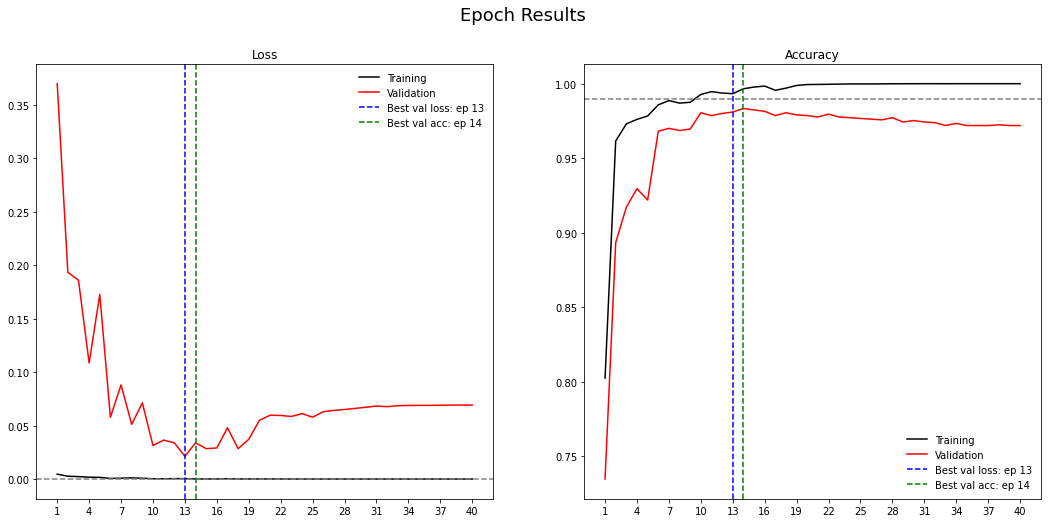

In [22]:
fig = plt.figure(figsize = (18, 8))
fig.suptitle('Epoch Results', fontsize = 18)

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

# x_ticks according to CFG.N_EPOCHS for better visuailzation
if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# Loss plot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(abscissa, train_loss_history, label='Training', color = 'black')
ax1.plot(abscissa, valid_loss_history, label='Validation', color = 'red')
plt.xticks(x_ticks)
plt.axhline(0, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title("Loss")
ax1.legend(frameon=False);

# Accuracy plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(abscissa, train_acc_history, label='Training', color = 'black')
ax2.plot(abscissa, valid_acc_history, label='Validation', color = 'red')
plt.xticks(x_ticks)
plt.axhline(0.99, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title("Accuracy")
ax2.legend(frameon=False);

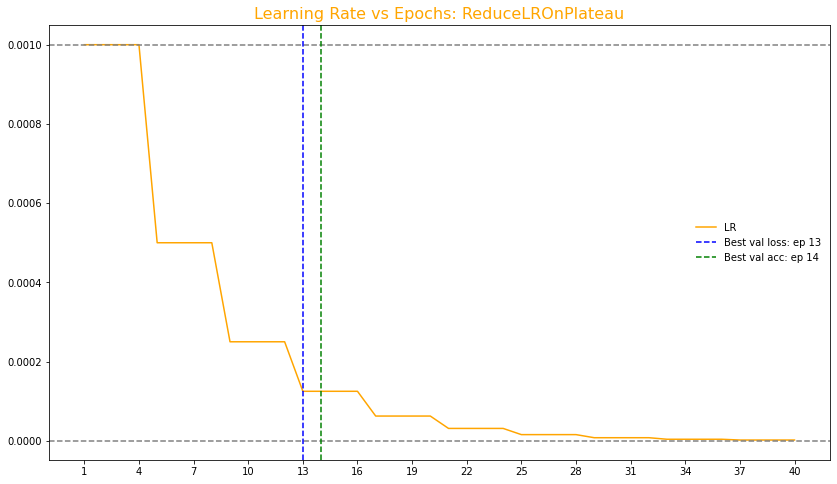

In [23]:
fig = plt.figure(figsize = (14, 8))

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

# x_ticks according to CFG.N_EPOCHS for better visuailzation
if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# LR plot
plt.plot(abscissa, LR_history, label='LR', color = 'orange')
plt.xticks(x_ticks)
plt.axhline(CFG.LEARNING_RATE, linestyle = 'dashed', color = 'grey')
plt.axhline(0, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title(f"Learning Rate vs Epochs: {CFG.scheduler}", fontsize = 16, color = 'orange')
plt.legend(frameon=False);

## Inference

In [24]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

def inference(test_loader, model):
    model.eval()

    predictions = []

    size = len(test_loader.dataset)
    num_batches = len(test_loader)    

    model = DigitModel().to(device)

    if CFG.save_best_loss: # load model with best validation loss
      model.load_state_dict(torch.load(OUTPUT_PATH + f"DigitModel_ep{best_epoch_loss}.pth"))
    else: # load model with best validation accuracy
      model.load_state_dict(torch.load(OUTPUT_PATH + f"DigitModel_ep{best_epoch_acc}.pth"))

    # disable gradients for inference
    with torch.no_grad():
      for batch, X in enumerate(test_loader):
        
        ################################# inference #################################
        start = time.time()
        current = batch * len(X)

        X = X.to(device)

        # compute predictions
        pred = model(X)       
        # softmax
        y_pred = softmax(pred.detach().cpu().numpy()) # convert tensor to numpy and apply softmax 
        y_pred = np.argmax(y_pred, axis = 1) # take the indice of the max value (higher probability: predicted class)

        # store results
        predictions.append(y_pred)

        # log
        end = time.time()
        time_delta = np.round(end - start, 5)

        # if batch % (CFG.print_freq) == 0:
        #   print(f"Inference Batch: {current:>5d}/{size:>5d}: Elapsed Time: {time_delta} s")          

    test_predictions = np.concatenate(predictions, axis = 0) # join sequence of arrays along axis 0
    return test_predictions

### instantiate Inference Dataset class (create inference Dataset)

In [25]:
inference_dataset = DigitInferenceDataset(test, augmentations=None)

# create Inference DataLoader object from Dataset class object
inference_dataloader = DataLoader(inference_dataset,
                                  batch_size = CFG.BATCH_SIZE,
                                  shuffle = False)

In [26]:
%%time
# run inference
predictions = inference(inference_dataloader, model)
predictions

CPU times: user 2.44 s, sys: 132 ms, total: 2.58 s
Wall time: 2.59 s


array([2, 0, 9, ..., 3, 9, 2])

## Submission

In [27]:
submission = pd.read_csv(INPUT_PATH + "sample_submission.csv")
submission["Label"] = predictions

submission.to_csv(OUTPUT_PATH + 'submission.csv', index = False)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


## Check predictions

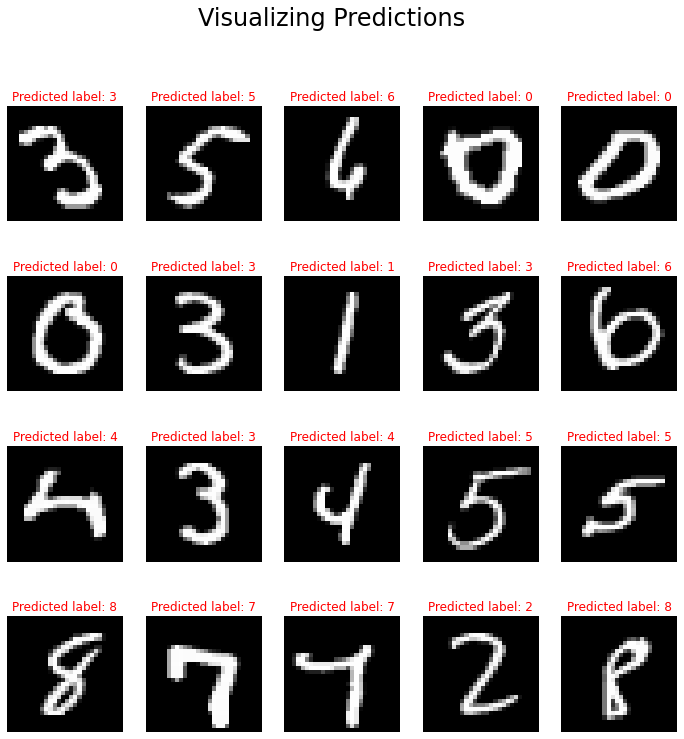

In [28]:
# check some predictions

fig = plt.figure(figsize = (12, 12))
fig.suptitle('Visualizing Predictions', fontsize = 24)

# define a range of predictions to plot
begin = 130
end = begin + 20

for i in range(begin, end):

  img = np.array(test.iloc[i, :]).reshape(1, 1, 28, 28) # reshape to image dimensions
  plt.subplot(4, 5, i + 1 - begin) # 4 rows and 5 columns plot 
  label = str(submission.loc[i, 'Label'])
  plt.title("Predicted label: " + label, color="red") # write label in each image title
  plt.imshow(np.squeeze(img), cmap='gray') # plot image
  plt.axis('off')